In [18]:
import numpy as np
from scipy.special import lpmn, factorial
from multipole import Vlm
from multipole_test import operation as op

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('ggplot')
def plot_3d(x):
    """plot particles in 3 dimentional"""
    y = np.transpose(x)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(y[0], y[1], y[2])
    ax = ax.view_init(30)
    plt.show()
    return 

# Step 1 Multipole Expansion for a single particle-pair

In [3]:
# Case 1 Construction
r1 = [2, 0.3*np.pi, 0.25*np.pi]
r2 = [16.5, 0.3*np.pi, 0.75*np.pi]
r = [r1, r2]
x = op.spherical_to_cartesian(r)

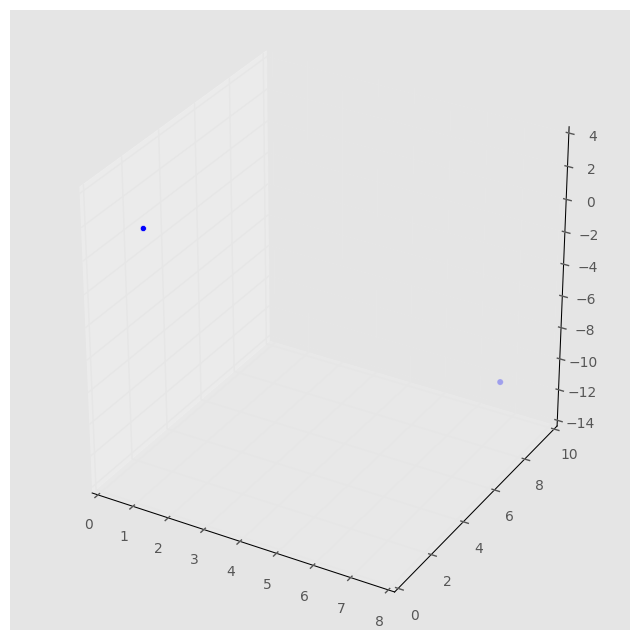

In [4]:
plot_3d(x)

In [5]:
[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(x)
X0 = op.cartesian_scaling_by_input_factor(np.array([0, 0, 0]), scale_factor)
r0_i = op.cartesian_to_spherical(x0_i-X0)

In [6]:
1 / (op.distance_cal(x0_i[0], x0_i[1]) * scale_factor[1])

0.06016574392530244

In [7]:
p0 = 5

Mlm = op.M_expansion(p0, r0_i[1])
Olm = op.O_expansion(p0, r0_i[0])

potential = Mlm.product(Olm).sum()
potential / scale_factor[1]

(0.062813923664993665+0j)

# Step 2 Build Conversion/Translation operators and calculating interaction between two boxes of particle in long distance

In [8]:
# Case 2 Construction
box_size = 1 
X = np.ndarray(shape=(2,3)) #Cartesian coordiantes of box centers
X[0] = [5,3,4]
X[1] = [-20,-4,-3]
num_charge = 20
x_i = np.ndarray(shape=(2*num_charge,3))

for i in range(0, num_charge):
    xi_dev = np.random.rand(3)
    x_i[i] = X[0] + xi_dev - 0.5
    xi_dev = np.random.rand(3)
    x_i[i+num_charge] = X[1] + xi_dev - 0.5

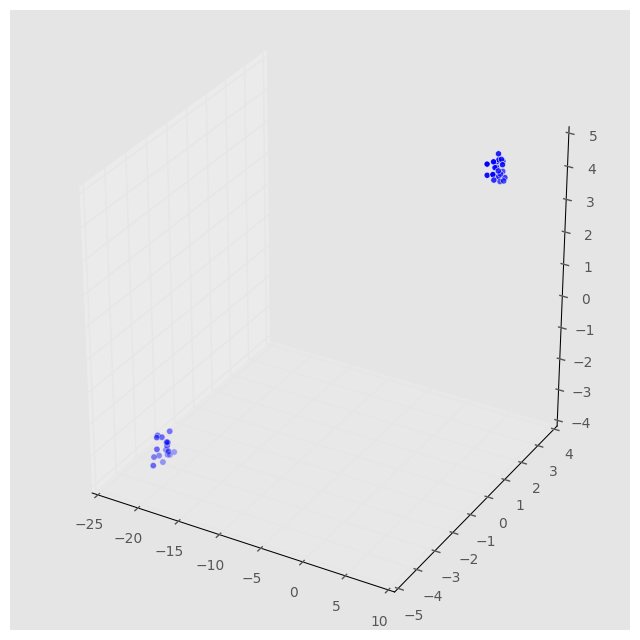

In [9]:
plot_3d(x_i)

In [10]:
[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(x_i)
X0 = op.cartesian_scaling_by_input_factor(X, scale_factor)

In [11]:
x1_k = x0_i[0:num_charge] - X0[0]
r1_k = op.cartesian_to_spherical(x1_k)
x2_k = x0_i[num_charge:num_charge*2] - X0[1]
r2_k = op.cartesian_to_spherical(x2_k)

analytic_potential = 0 
for i in range(0, num_charge):
    for j in range(0, num_charge):
        analytic_potential += 1 / op.distance_cal(x0_i[i], x0_i[j+num_charge])

analytic_potential / scale_factor[1]

14.923246557356352

In [12]:
# test on conversion operation
p1 = 5

Olm_Q1_x1_k = Vlm(p1) # multiple moment Omegalm(Q1; {x1_k}), Q1 = sum(q_k)
for i in range(0, num_charge):
    Olm_Q1_x1_k.add(op.O_expansion(p1, r1_k[i]))

X12 = X0[1] - X0[0]
X21 = X0[0] - X0[1]
Mlm_Q1_x2_k = op.O_to_M(Olm_Q1_x1_k, X12)

numerical_potential = 0
for j in range(0, num_charge):
    Olm_q2_x2_k = op.O_expansion(p1, r2_k[j])
    numerical_potential += Olm_q2_x2_k.product(Mlm_Q1_x2_k).sum()

numerical_potential /= scale_factor[1]

numerical_potential

(14.893064347764339+0j)

In [13]:
Olm_Q2_x2_k = Vlm(p1) # multiple moment Omegalm(Q1; {x1_k}), Q1 = sum(q_k)
for i in range(0, num_charge):
    Olm_Q2_x2_k.add(op.O_expansion(p1, r2_k[i]))

Mlm_Q2_x1_k = op.O_to_M(Olm_Q2_x2_k, X21)

numerical_potential_2 = 0
for j in range(0, num_charge):
    Olm_q1_x1_k = op.O_expansion(p1, r1_k[j])
    numerical_potential_2 += Olm_q1_x1_k.product(Mlm_Q2_x1_k).sum()

numerical_potential_2 /= scale_factor[1]

numerical_potential_2

(14.897241522141647+0j)

In [14]:
# test on translation operators
X = np.ndarray(shape=(4,3)) #Cartesian coordiantes of box centers
X[0] = [5,3,4]
X[1] = [-20,-4,-3]
X[2] = [5, 4, 5]
X[3] = [-20, -5, -5]
X0 = op.cartesian_scaling_by_input_factor(X, scale_factor)

In [15]:
p1 = 5

Olm_Q1_x1_k = Vlm(p1) # multiple moment Omegalm(Q1; {x1_k}), Q1 = sum(q_k)
for i in range(0, num_charge):
    Olm_Q1_x1_k.add(op.O_expansion(p1, r1_k[i]))
    
X31 = X0[0] - X0[2]
Olm_Q1_x3_k = op.O_to_O(Olm_Q1_x1_k, X31)
    
X32 = X0[1] - X0[2]
Mlm_Q1_x2_k = op.O_to_M(Olm_Q1_x3_k, X32)

numerical_potential = 0
for j in range(0, num_charge):
    Olm_q2_x2_k = op.O_expansion(p1, r2_k[j])
    numerical_potential += Olm_q2_x2_k.product(Mlm_Q1_x2_k).sum()

numerical_potential /  scale_factor[1] 

(14.591480901378247+2.091385413420397e-21j)

In [16]:
p1 = 5

Olm_Q1_x1_k = Vlm(p1) # multiple moment Omegalm(Q1; {x1_k}), Q1 = sum(q_k)
for i in range(0, num_charge):
    Olm_Q1_x1_k.add(op.O_expansion(p1, r1_k[i]))
    
X12 = X0[1] - X0[0]
X21 = X0[0] - X0[1]
Mlm_Q1_x2_k = op.O_to_M(Olm_Q1_x1_k, X12)

X24 = X0[3] - X0[1]
Mlm_Q1_x4_k = op.M_to_M(Mlm_Q1_x2_k, X24)

x4_k = x0_i[num_charge:num_charge*2] - X0[3]
r4_k = op.cartesian_to_spherical(x4_k)

numerical_potential = 0
for j in range(0, num_charge):
    Olm_q2_x4_k = op.O_expansion(p1, r4_k[j])
    numerical_potential += Olm_q2_x4_k.product(Mlm_Q1_x4_k).sum()

numerical_potential /  scale_factor[1]

(15.138981139934305-5.3539466583562163e-19j)

In [17]:
p1 = 5

Olm_Q1_x1_k = Vlm(p1) # multiple moment Omegalm(Q1; {x1_k}), Q1 = sum(q_k)
for i in range(0, num_charge):
    Olm_Q1_x1_k.add(op.O_expansion(p1, r1_k[i]))
    
X31 = X0[0] - X0[2]
Olm_Q1_x3_k = op.O_to_O(Olm_Q1_x1_k, X31)
    

X32 = X0[1] - X0[2]
Mlm_Q1_x2_k = op.O_to_M(Olm_Q1_x3_k, X32)

X24 = X0[3] - X0[1]
Mlm_Q1_x4_k = op.M_to_M(Mlm_Q1_x2_k, X24)

x4_k = x0_i[num_charge:num_charge*2] - X0[3]
r4_k = op.cartesian_to_spherical(x4_k)

numerical_potential = 0
for j in range(0, num_charge):
    Olm_q2_x4_k = op.O_expansion(p1, r4_k[j])
    numerical_potential += Olm_q2_x4_k.product(Mlm_Q1_x4_k).sum()

numerical_potential /  scale_factor[1]

(14.798721759530693-5.3539466583562163e-18j)

In [ ]:
np.abs(numerical_potential.real - analytic_potential.real) / numerical_potential.real